Fecha inicio: 2020-01-01 00:00:00
Fecha fin: 2024-06-30 00:00:00
Total number of days: 1642 days 00:00:00
Epoch [100/2866], Train Loss: 0.0037, Val Loss: 0.0076
Early stopping!


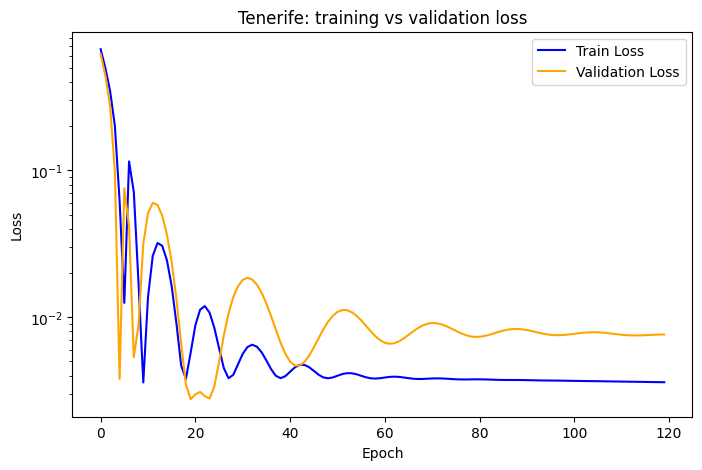

Evaluation Metrics:
MAE: 545.6557
MSE: 372816.4961
RMSE: 610.5870
R2: -1.1588
MAPE: 0.0614
sMAPE: 0.0636


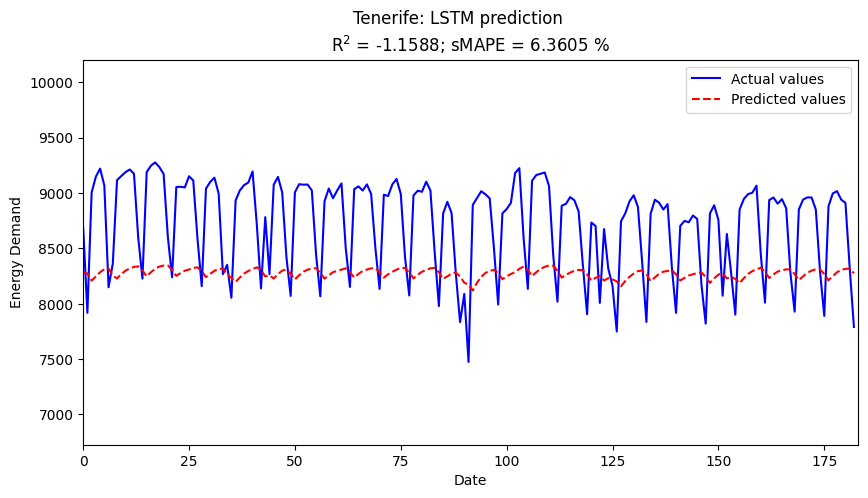



Epoch [100/2866], Train Loss: 0.0026, Val Loss: 0.0043
Early stopping!


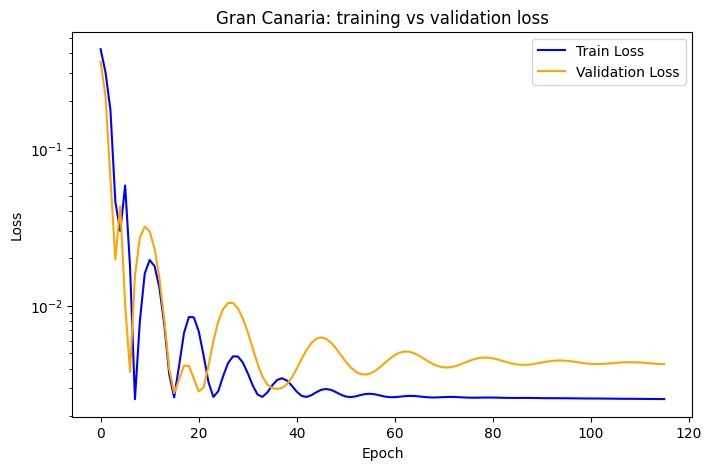

Evaluation Metrics:
MAE: 363.8615
MSE: 180853.5579
RMSE: 425.2688
R2: 0.0025
MAPE: 0.0438
sMAPE: 0.0437


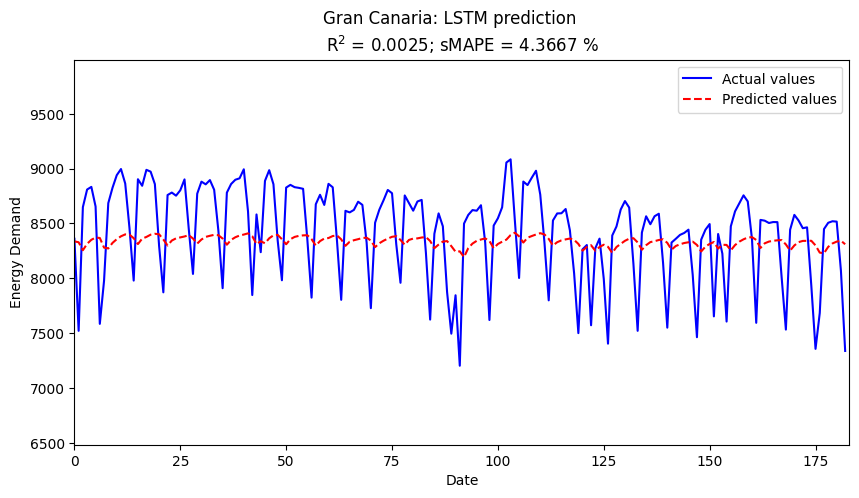



Epoch [100/2866], Train Loss: 0.0051, Val Loss: 0.0140
Early stopping!


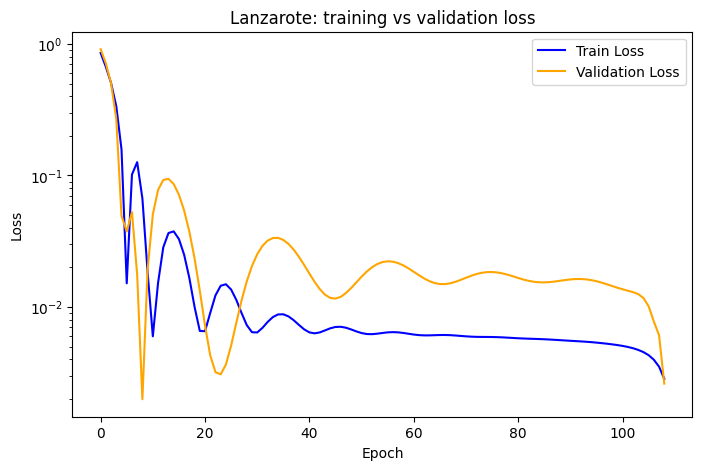

Evaluation Metrics:
MAE: 76.7082
MSE: 7362.0580
RMSE: 85.8024
R2: -1.1054
MAPE: 0.0341
sMAPE: 0.0348


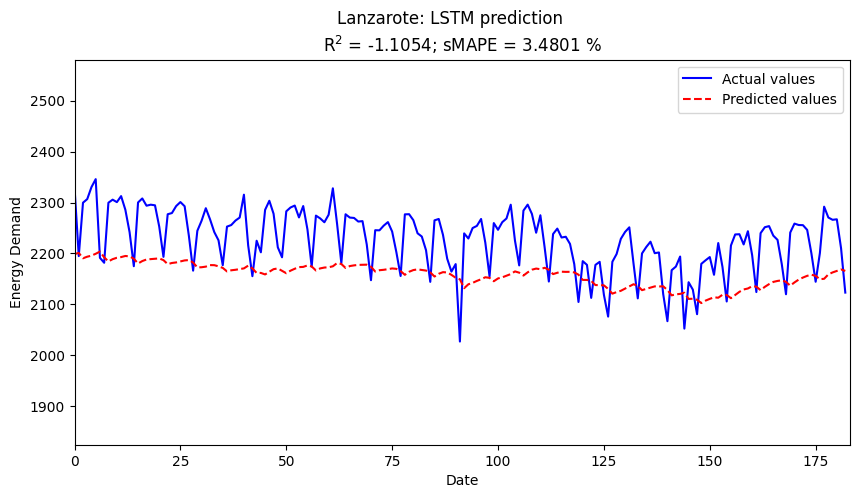



Epoch [100/2866], Train Loss: 0.0006, Val Loss: 0.0009
Epoch [200/2866], Train Loss: 0.0005, Val Loss: 0.0008
Epoch [300/2866], Train Loss: 0.0005, Val Loss: 0.0008
Epoch [400/2866], Train Loss: 0.0005, Val Loss: 0.0008
Epoch [500/2866], Train Loss: 0.0005, Val Loss: 0.0008
Early stopping!


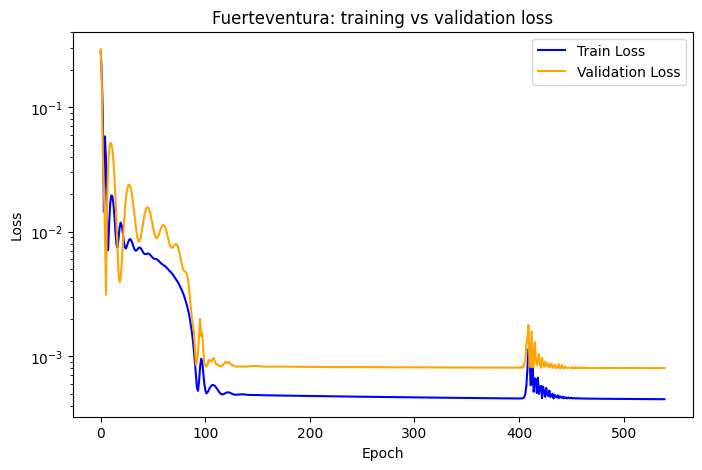

Evaluation Metrics:
MAE: 33.1505
MSE: 1788.4401
RMSE: 42.2900
R2: 0.2363
MAPE: 0.0196
sMAPE: 0.0195


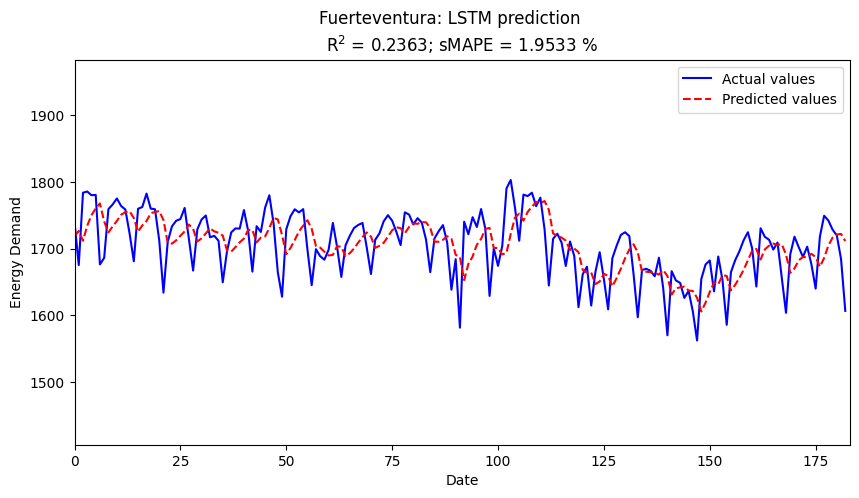



Epoch [100/2866], Train Loss: 0.0022, Val Loss: 0.0034
Early stopping!


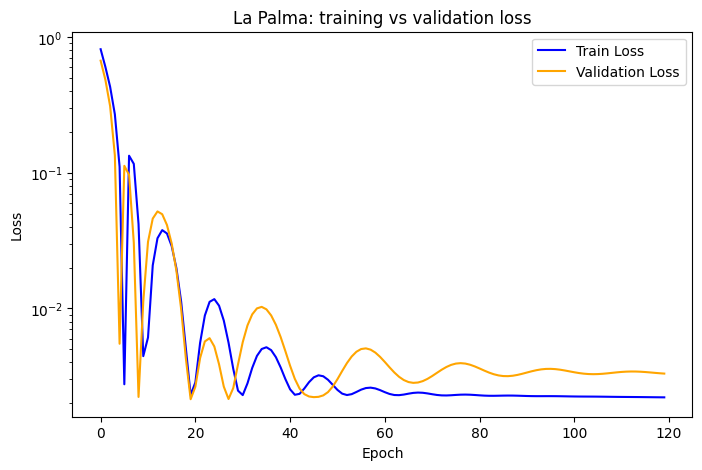

Evaluation Metrics:
MAE: 23.0491
MSE: 736.8846
RMSE: 27.1456
R2: -0.1454
MAPE: 0.0358
sMAPE: 0.0361


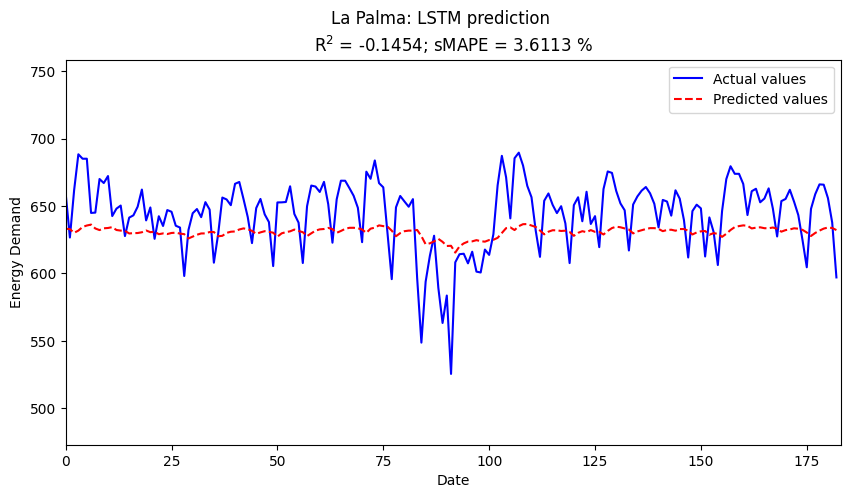



Epoch [100/2866], Train Loss: 0.0025, Val Loss: 0.0051
Early stopping!


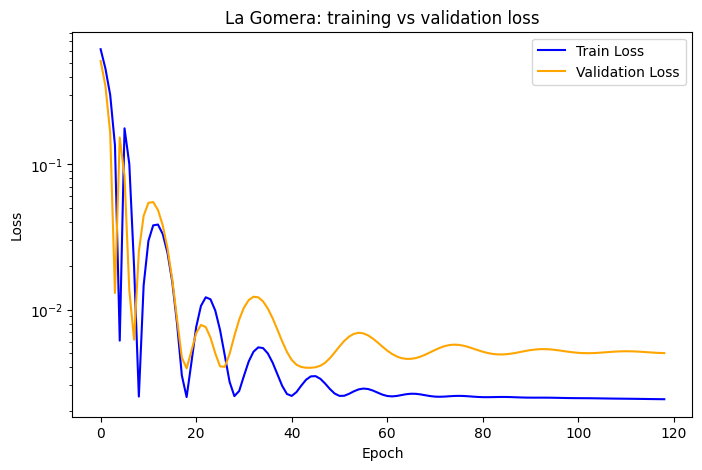

Evaluation Metrics:
MAE: 5.7152
MSE: 53.2261
RMSE: 7.2956
R2: 0.0873
MAPE: 0.0334
sMAPE: 0.0331


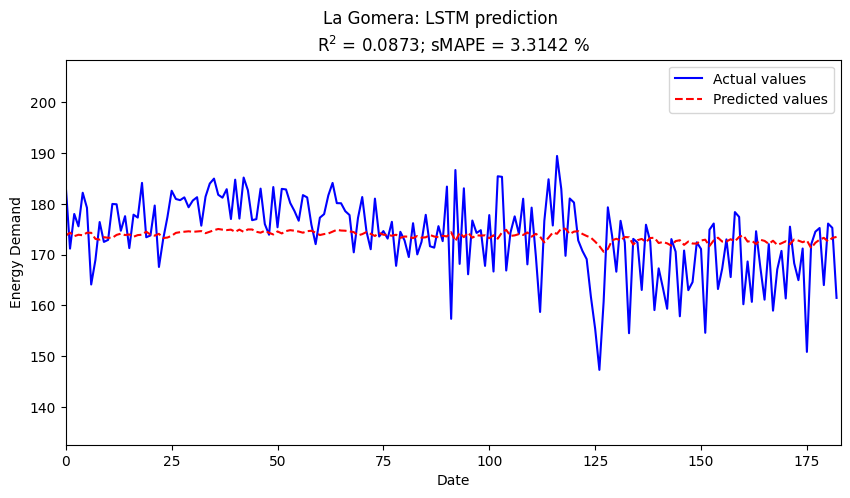



Epoch [100/2866], Train Loss: 0.0035, Val Loss: 0.0090
Early stopping!


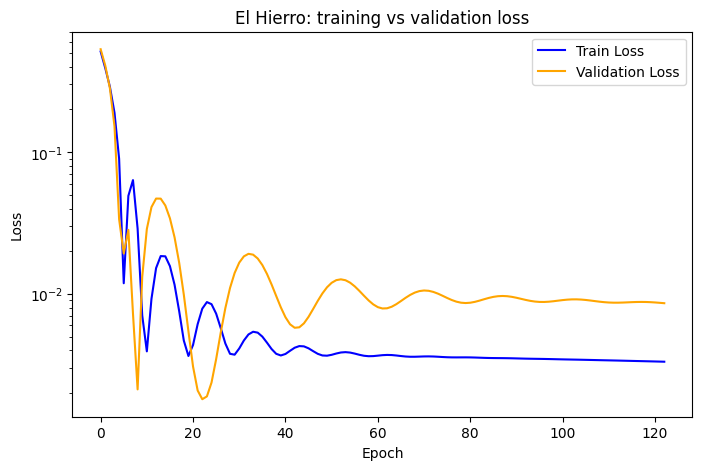

Evaluation Metrics:
MAE: 9.5077
MSE: 104.3441
RMSE: 10.2149
R2: -4.3485
MAPE: 0.0708
sMAPE: 0.0737


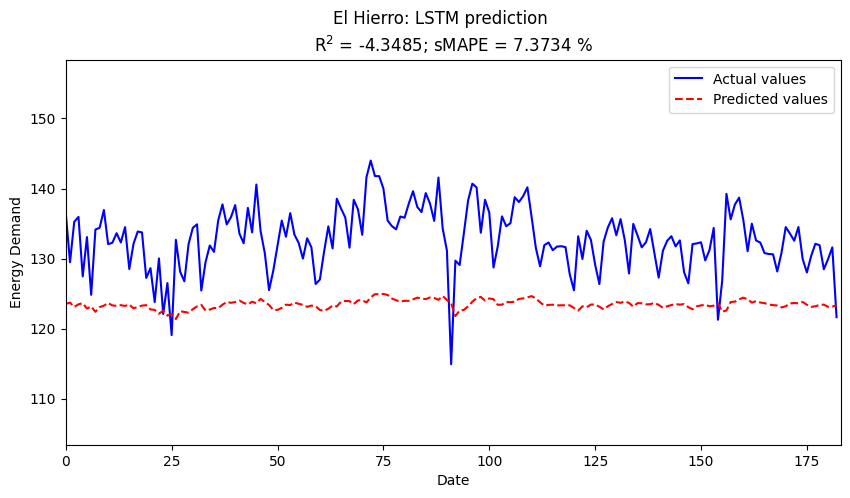

In [1]:
import random

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.animation as animation

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler

from src.utils import metrics
from src.utils import data_loader as d
from src.utils import models

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

islas_dfs = d.local_data_loader()

islas = ['Tenerife', 'Gran Canaria', 'Lanzarote', 'Fuerteventura', 'La Palma', 'La Gomera', 'El Hierro']
for isla in islas:
    # Extract energy demand values and reshape for scaling
    energy = islas_dfs[isla]['OBS_VALUE'].values.reshape(-1,1) # data['energy'].values.reshape(-1, 1)

    # Scale the data to [0,1] for easier training
    scaler = MaxAbsScaler()
    energy_scaled = scaler.fit_transform(energy)

    # ======= 2. Train-Validation-Test Split =======
    train_size = 1460  # First 4 years for training/validation
    val_size = int(0.2 * train_size)  # 20% of training data for validation
    window_size = 30 # 30  # Window size for sequences

    # Split into training, validation, and test sets
    train_data = energy_scaled[:train_size - val_size]
    val_data = energy_scaled[train_size - val_size:train_size]
    test_data = energy_scaled[train_size - window_size:]

    # Utility function: create input-output sequences using a sliding window
    def create_sequences(data, window_size):
        sequences = []
        targets = []
        for i in range(len(data) - window_size):
            seq = data[i:i + window_size]
            target = data[i + window_size]
            sequences.append(seq)
            targets.append(target)
        return np.array(sequences), np.array(targets)

    # Create sequences for training and validation
    train_sequences, train_targets = create_sequences(train_data, window_size)
    val_sequences, val_targets = create_sequences(val_data, window_size)

    # Convert to PyTorch tensors
    train_sequences = torch.tensor(train_sequences, dtype=torch.float32)
    train_targets = torch.tensor(train_targets, dtype=torch.float32)
    val_sequences = torch.tensor(val_sequences, dtype=torch.float32)
    val_targets = torch.tensor(val_targets, dtype=torch.float32)

    model = models.LSTMModel(hidden_size=32) # --> 0.71

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-2)


    num_epochs = 2866 # best without overfitting
    train_losses, val_losses = [], []
    early_stopping_patience = 100
    best_val_loss = float('inf')
    stopping_counter = 0
    early_stopping = True


    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        output = model(train_sequences)
        train_loss = criterion(output, train_targets)
        train_loss.backward()
        optimizer.step()

        # Validation step
        model.eval()
        with torch.no_grad():
            val_output = model(val_sequences)
            val_loss = criterion(val_output, val_targets)


        train_losses.append(train_loss.item())
        val_losses.append(val_loss.item())

        if val_loss.item() < best_val_loss:
            best_val_loss = val_loss.item()
            stopping_counter = 0
        else:
            stopping_counter += 1

        if early_stopping and stopping_counter >= early_stopping_patience:
            print('Early stopping!')
            break

        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

    # ======= 5. Plot Training vs Validation Loss =======
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Train Loss', color='blue')
    plt.plot(val_losses, label='Validation Loss', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.title(f'{isla}: training vs validation loss')
    plt.legend()
    plt.show()

    test_sequences, test_targets = create_sequences(test_data, window_size)
    test_sequences = torch.tensor(test_sequences, dtype=torch.float32)
    test_targets = torch.tensor(test_targets, dtype=torch.float32)

    online_predictions = []
    actual_values = []

    online_optimizer = optim.Adam(model.parameters(), lr=1e-6)

    for i in range(len(test_sequences)):
        x = test_sequences[i].unsqueeze(0)

        model.eval()
        with torch.no_grad():
            pred = model(x)
        online_predictions.append(pred.item())
        actual_values.append(test_targets[i].item())

        # Online learning step
        model.train()
        online_optimizer.zero_grad()
        pred_online = model(x)
        loss_online = criterion(pred_online, test_targets[i].unsqueeze(0))
        loss_online.backward()
        online_optimizer.step()

    # Inverse transform
    online_predictions_inv = scaler.inverse_transform(np.array(online_predictions).reshape(-1, 1)).flatten()
    actual_values_inv = scaler.inverse_transform(np.array(actual_values).reshape(-1, 1)).flatten()

    metrics_result = metrics.all_metrics(actual_values_inv, online_predictions_inv)
    print("Evaluation Metrics:")
    for metric, value in metrics_result.items():
        print(f"{metric}: {value:.4f}")

    fig, ax = plt.subplots(figsize=(10, 5))
    plt.suptitle(f'{isla}: LSTM prediction')
    ax.set_xlim(0, len(actual_values_inv))
    ax.set_ylim(min(actual_values_inv) * 0.9, max(actual_values_inv) * 1.1)
    ax.set_xlabel("Date")
    ax.set_ylabel("Energy Demand")
    ax.set_title(f"R$^2$ = {metrics_result['R2']:.4f}; sMAPE = {100*metrics_result['sMAPE']:.4f} %")
    ax.plot(actual_values_inv, label = 'Actual values', color = 'blue')
    ax.plot(online_predictions_inv, '--r' ,label = 'Predicted values')
    ax.legend()
    plt.savefig
    plt.show()
    print('\n')